In [5]:
import os
from os import path as op
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
import seaborn as sns
from scipy import stats

from mne import (read_evokeds, grand_average, combine_evoked,
                 read_epochs)
from mne.stats import permutation_t_test, permutation_cluster_test
from mne.utils import _time_mask
from mne.evoked import _get_peak
from mne.epochs import combine_event_ids

%reload_ext pycodestyle_magic
# %matplotlib qt
# time.sleep(1)

In [6]:
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['grid.color'] = '0.75'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['lines.markersize'] = '0.5'
leg_kwargs = dict(frameon=False, columnspacing=0.1, labelspacing=0.1,
                  fontsize=8, fancybox=False, handlelength=2.0,
                  loc='upper right')


def box_off(ax):
    """helper to format axis tick and border"""
    # Ensure axis ticks only show up on the bottom and left of the plot.
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    # Remove the plot frame lines.
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    for axis in (ax.get_xaxis(), ax.get_yaxis()):
        for line in [ax.spines['left'], ax.spines['bottom']]:
            line.set_zorder(3)
        for line in axis.get_gridlines():
            line.set_zorder(1)
    ax.grid(True)


def r2(x, y):
    """helper to return Pearson correlation coeffecient"""
    return stats.pearsonr(x, y)[0] ** 2


In [7]:
sys.path.append('/home/ktavabi/Projects/bad-baby')
data_dir = '/home/ktavabi/Projects/bad-baby/data'
fig_dir = '/home/ktavabi/Projects/bad-baby/data/figures'
work_dir = '/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch'
df = pd.read_excel(op.join(data_dir, 'bad-baby.xls'), sheet_name='MMN',
                   converters={'BAD': str})
inclusion = df['Included'] == 1
df = df[inclusion]
df_demographs = pd.read_excel(op.join(data_dir, 'simms_demographics.xls'),
                              sheet_name='simms_demographics')
simms_subjects = pd.Series(np.intersect1d(df['Subject_ID'].values,
                                          df_demographs['Subject_ID'].values))
df_a = df[df['Subject_ID'].isin(simms_subjects.tolist())]
df_b = df_demographs[df_demographs['Subject_ID'].isin(simms_subjects.tolist())]
simms_df = pd.merge(df_a, df_b)
groups = np.unique(simms_df.Group).tolist()
remap = dict([(2, '2 months'), (6, '6 months')])
titles_comb = [remap[kind] for kind in [2, 6]]
N = max([len(np.where(simms_df.Group == g)[0]) for g in groups])
ts_args = {'gfp': True}
topomap_args = {'outlines': 'skirt', 'sensors': False}

Peak latency for 2 mos at 
 MEG144X at 0.277ms


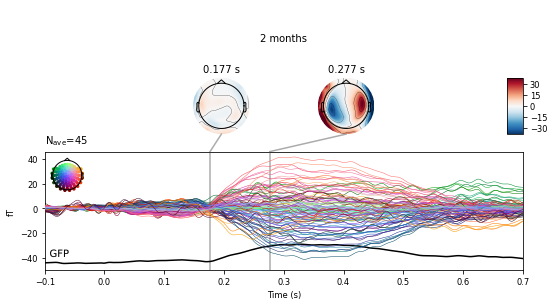

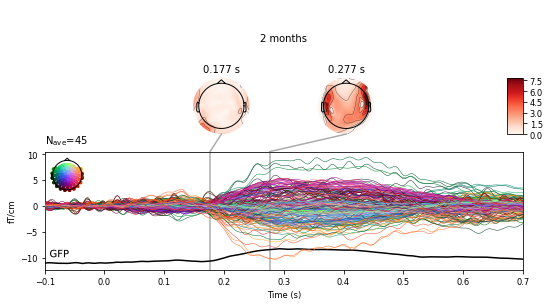

Number of significant sensors : 0
Sensors names : MEG[]


ValueError: Info (204) and data (306) must have same number of channels.

In [19]:
# Group ERFs
analysis = 'All'
conditions = ['All']
lpf = 40

peak_lats = list()
peak_chs = list()
for ii, group in enumerate(groups):
    subjects = simms_df[simms_df.Group == group].Subject_ID.values.tolist()
    n = len(subjects)
    evokeds = list()
    file_out = op.join(work_dir, '%s_%smos_%d_grd-ave.fif'
                       % (analysis, groups[ii], lpf))
    for si, sub in enumerate(subjects):
        evoked_file = op.join(work_dir, 'bad_%s' % sub, 'inverse',
                              '%s_%d-sss_eq_bad_%s-ave.fif' % (analysis,
                                                               lpf,
                                                               sub))
        evoked = read_evokeds(evoked_file, condition=conditions[0],
                              baseline=(None, 0))
        if evoked.info['sfreq'] > 600.0:
            raise ValueError('bad_%s - %dHz Wrong sampling rate!'
                             % (sub, evoked.info['sfreq']))
        if sub == subjects[0]:
            erf_data = np.zeros((len(subjects), len(evoked.info['chs']),
                                len(evoked.times)))
            erf_data[si] = evoked.data    
        evokeds.append(evoked.copy())
    
    # do grand averaging
    if not op.isfile(file_out):
        grandavr = grand_average(evokeds)
        grandavr.save(file_out)
    else:
        grandavr = read_evokeds(file_out)[0]
    
    # peak ERF latency from gradiometer RMS    
    ch, lat = grandavr.get_peak(ch_type='grad', merge_grads=True, 
                                tmin=.1, tmax=.5)
    peak_chs.append(ch)
    peak_lats.append(lat)
    print('Peak latency for %s mos at \n %s at %0.3fms' 
          % (group, peak_chs[ii], peak_lats[ii]))
    # look at 100ms rising slope to peak 
    timing = [peak_lats[ii] - .1, peak_lats[ii]]
    hs = grandavr.plot_joint(title=titles_comb[ii],
                             times=timing, ts_args=ts_args,
                             topomap_args=topomap_args)
    for h, ch_type in zip(hs, ['grad', 'mag']):
        fig_out = op.join(fig_dir, '%s_%s_%d_%s_grd-ave.eps'
                              % (analysis, groups[ii], lpf, 
                                 ch_type))
        h.savefig(fig_out, dpi=300, format='eps')
    # Apply temporal mask to select time window
    times = grandavr.times
    temporal_mask = np.logical_and(peak_lats[ii] - .15 <= times, 
                                   times <= peak_lats[ii])
    picks = mne.pick_types(grandavr.info)
    grandavr.pick_types(meg='grad', exclude=[])
    data = np.mean(erf_data[:, :, temporal_mask], axis=2)
    # T-test
    T0, p_values, H0 = permutation_t_test(data, n_permutations=1000, n_jobs=18)
    # find significant sensors
    significant_sensors = picks[p_values <= .05]
    print("Number of significant sensors : %d" % len(significant_sensors))
    print("Sensors names : MEG%s" % significant_sensors)
    evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                             grandavr.info, tmin=0.)
    stats_picks = mne.pick_channels(grandavr.ch_names, significant_sensors)
    mask = p_values[:, np.newaxis] <= 0.05
    fig = evoked.plot_topomap(ch_type='grad', times=[0], scale=1, 
                              time_format=None, cmap='Reds', vmin=0., vmax=np.max,
                              unit='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                              size=3, show_names=lambda x: x[0:] + ' ' * 20)
    fig.savefig(op.join(fig_dir, '%s_%s_%d_spm.png' % (analysis, lpf)))

This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/2 months_Oddball_standard_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz


<ipython-input-17-203fa3c35460>:29: RuntimeWarning: This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/2 months_Oddball_standard_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  grandavr.save(file_out)


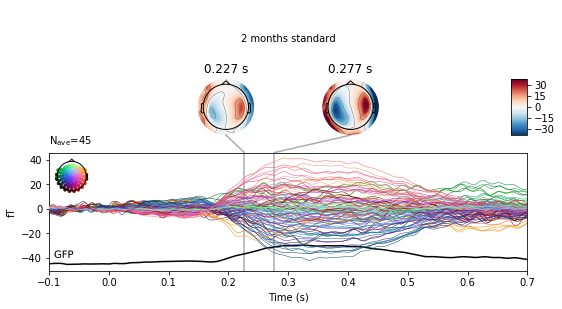

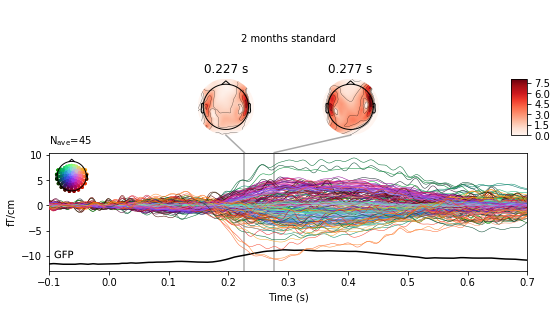

This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/2 months_Oddball_deviant_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz


<ipython-input-17-203fa3c35460>:29: RuntimeWarning: This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/2 months_Oddball_deviant_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  grandavr.save(file_out)


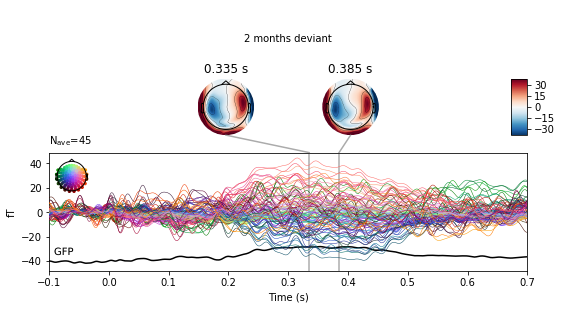

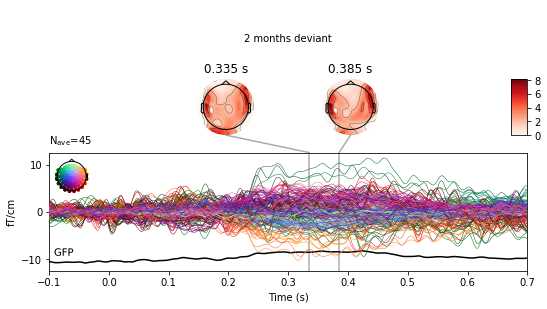

This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/6 months_Oddball_standard_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz


<ipython-input-17-203fa3c35460>:29: RuntimeWarning: This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/6 months_Oddball_standard_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  grandavr.save(file_out)


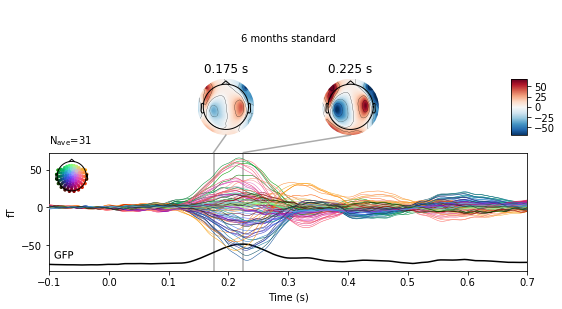

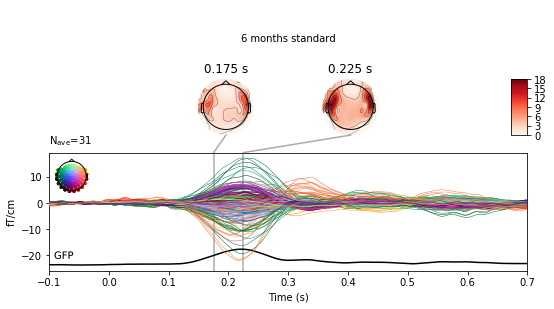

This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/6 months_Oddball_deviant_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz


<ipython-input-17-203fa3c35460>:29: RuntimeWarning: This filename (/media/ktavabi/ALAYA/data/ilabs/bad-baby/mismatch/6 months_Oddball_deviant_40_g-avr.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  grandavr.save(file_out)


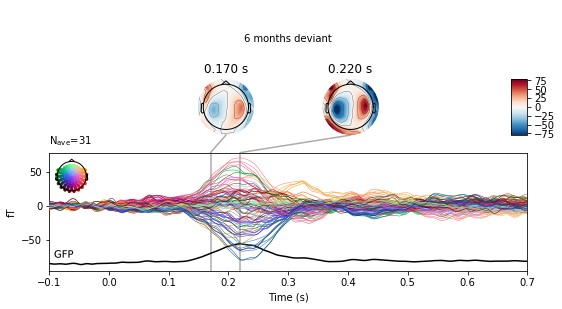

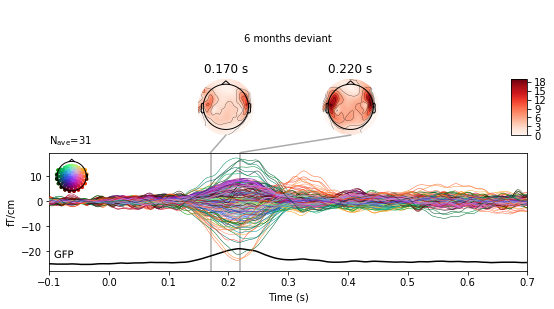

Peak latency for 2 mos at 
 MEG151X at 0.385ms
Peak latency for 6 mos at 
 MEG151X at 0.220ms


In [17]:
# Group ERFs for oddball conditions
analysis = 'Oddball'
conditions = ['standard', 'deviant']
colors = dict(deviant="Crimson", standard="CornFlowerBlue")
lpf = 40
peak_lats = list()
peak_chs = list()
for ii, group in enumerate(groups):
    subjects = simms_df[simms_df.Group == group].Subject_ID.values.tolist()
    n = len(subjects)
    for cond in conditions:
        evokeds = list()
        file_out = op.join(work_dir, '%s_%smos_%d_gavr.fif'
                       % (analysis, groups[ii], lpf))
        for si, subj in enumerate(subjects):
            evoked_file = op.join(work_dir, 'bad_%s' % subj, 'inverse',
                                  '%s_%d-sss_eq_bad_%s-ave.fif'
                                  % (analysis, lpf, subj))
            evoked = read_evokeds(evoked_file, condition=cond,
                                  baseline=(None, 0))
            if evoked.info['sfreq'] > 600.0:
                raise ValueError('bad_%s - %dHz Wrong sampling rate!' 
                                 % (sub, evoked.info['sfreq']))
            evokeds.append(evoked.copy())
    
        # do grand averaging
        if not op.isfile(file_out):
            grandavr = grand_average(evokeds)
            grandavr.save(file_out)
        else:
            grandavr = read_evokeds(file_out)[0]

        # peak deviant ERF latency from gradiometer RMS    
        ch, lat = grandavr.get_peak(ch_type='grad', merge_grads=True, 
                                    tmin=.1, tmax=.4)
        if cond == 'deviant':
            peak_lats.append(lat)
            peak_chs.append(ch)
        # rising slope peak deviant activity                    
        timing = [lat - .05, lat]  
        hs = grandavr.plot_joint(title=titles_comb[ii] + ' ' + cond,
                                 times=timing, ts_args=ts_args,
                                 topomap_args=topomap_args)
        for h, ch_type in zip(hs, ['grad', 'mag']):
            fig_out = op.join(fig_dir, '%s_%s_%s_%d_%s_gavr.eps'
                              % (analysis, groups[ii], cond, lpf, 
                                 ch_type))
            h.savefig(fig_out, dpi=300, format='eps')

for gi, g in enumerate(groups):
    print('Peak latency for %s mos at \n %s at %0.3fms' 
          % (g, peak_chs[gi], peak_lats[gi]))            


In [ ]:
# Lets see how sensor ts look across Groups
conditions = ['standard', 'deviant']
colors = dict(deviant="Crimson", standard="CornFlowerBlue")
# picks = dict([(2, ['MEG1332', 'MEG1333']), (6, ['MEG0232', 'MEG0233'])])
# picks = dict([(2, ['MEG1331']), (6, ['MEG0231'])])
picks = {'lh': ['MEG0232', 'MEG0233', 'MEG0242', 'MEG0243',
                'MEG0222', 'MEG0223', 'MEG0212', 'MEG0213',
                'MEG1622', 'MEG1623', 'MEG1612', 'MEG1613'],
         'rh': ['MEG1342', 'MEG1343', 'MEG1332', 'MEG1333',
               'MEG1312', 'MEG1313', 'MEG1322', 'MEG1323',
               'MEG2412', 'MEG2413', 'MEG2422', 'MEG2423']}
for ii, group in enumerate(groups):
    evoked_dict = dict()
    n = len(df[df.Group == group].Subject_ID.values.tolist())
    use_this = group
    group = remap[group]
    # read in grand average ERF data
    for condition in conditions:
        fname = op.join(workdir, '%s_Oddball-matched_%s_40_n%d_grand-ave.fif' % (group, condition, n))
        evoked_dict[condition] = mne.read_evokeds(fname, baseline=(None, 0), condition=None)[0]
    
    for k in picks.iterkeys():
         pick = [evokeds[-1].ch_names.index(jj) for jj in picks[k]]
         mne.viz.plot_compare_evokeds(evokeds=evoked_dict, picks=pick, colors=colors,
                                      title=titles_comb[ii] + ' Oddball Stimuli')

In [ ]:
# Lets see data dispersion for maximally responsive channel(s) for oddball conditions
analysis = 'Oddball-matched'
conditions = ['standard', 'deviant']
picks = {'lh': ['MEG0231', 'MEG0232', 'MEG0233', 'MEG0241', 'MEG0242', 'MEG0243',
                'MEG0221', 'MEG0222', 'MEG0223', 'MEG0211', 'MEG0212', 'MEG0213',
                'MEG1621', 'MEG1622', 'MEG1623', 'MEG1611', 'MEG1612', 'MEG1613'],
         'rh': ['MEG1341', 'MEG1342', 'MEG1343', 'MEG1331', 'MEG1332', 'MEG1333',
                'MEG1311', 'MEG1312', 'MEG1313', 'MEG1321', 'MEG1322', 'MEG1323',
                'MEG2411', 'MEG2412', 'MEG2413', 'MEG2421', 'MEG2422', 'MEG2423']}
for ii, group in enumerate(groups):
    subjects = df[df.Group == group].Subject_ID.values
    evoked_dict = dict()
    n = len(df[df.Group == group].Subject_ID.values.tolist())
    for cond in conditions:
        evokeds = list()
        for si, subj in enumerate(subjects):
            evoked_file = op.join(workdir, 'bad_%s' % subj, 'inverse',
                                  '%s_%d-sss_eq_bad_%s-ave.fif'
                              % (analysis, lpf, subj))
            evokeds.append(read_evokeds(evoked_file, condition=cond,
                                        baseline=(None, 0)))
        evoked_dict[cond] = evokeds
    for k in picks.iterkeys():
        pick = [evokeds[-1].ch_names.index(jj) for jj in picks[k]]
        mne.viz.plot_compare_evokeds(evokeds=evoked_dict, picks=pick, 
                                     colors=colors, ci=.95, invert_y=True,
                                     title=titles_comb[ii] + ' Oddball Stimuli')


In [ ]:
np.arange(105, len(epochs.events)/2)

In [ ]:
# Permutation F-test on sensor data with temporal cluster
conditions = ['standard', 'deviant']
channel = ['MEG0241']
threshold = 6
for ii, group in enumerate([6]):
    subjects = df[df.Group == group].Subject_ID.values[:2]
    n = len(df[df.Group == group].Subject_ID.values.tolist())
    for si, subj in enumerate(subjects):
        epochs_file = op.join(workdir, 'bad_%s' % subj, 'epochs',
                              'All_%d-sss_bad_%s-epo.fif'
                              % (lpf, subj))
        info = mne.io.read_info(epochs_file)
        epochs = read_epochs(epochs_file, preload=False)
        combine_event_ids(epochs, ['ba', 'wa'], {'deviant': 106}, copy=False)
        epochs.equalize_event_counts(['standard', 'deviant'], method='truncate')
        print(len(epochs['standard'].events))
        print(len(epochs['deviant'].events))
        if len(epochs['standard'].events) > 105:
            epochs['standard'].drop(np.arange(105, len(epochs.events)/2))
        elif len(epochs['defiant'].events) > 105:
            epochs['deviant'].drop(np.arange(105, len(epochs.events)/2))
            
        print(epochs)
        

In [ ]:
        std_ch_ts = epochs['standard'].load_data().pick_types(meg=False, include=channel,
                                                              exclude='bads').get_data()[:, 0, :]
        dev_ch_ts = epochs['deviant'].load_data().pick_types(meg=False, include=channel,
                                                             exclude='bads').get_data()[:, 0, :]
        if ii == 0 and si == 0:
            condition1 = np.zeros((n, std_ch_ts.shape[0], std_ch_ts.shape[1]))
            condition2 = np.zeros((n, dev_ch_ts.shape[0], dev_ch_ts.shape[1]))
        while std_ch_ts.shape[0]
        condition1[si] = std_ch_ts
        condition2[si] = dev_ch_ts
    #T_obs, clusters, cluster_p_values, H0 = \
    #permutation_cluster_test([condition1, condition2], n_permutations=1000,
    #threshold=threshold, tail=1, n_jobs=18)
print(condition1.shape, condition2.shape)        
             